<a href="https://colab.research.google.com/github/ever-oli/MLby22/blob/main/NeuralNet_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data shapes - X: (2, 150), Y: (1, 150)

Commencing Network Training...
Epoch     0 | Cost: 0.693150
Epoch  1000 | Cost: 0.005303
Epoch  2000 | Cost: 0.002167
Epoch  3000 | Cost: 0.001349
Epoch  4000 | Cost: 0.000977
Epoch  5000 | Cost: 0.000765
Epoch  6000 | Cost: 0.000629
Epoch  7000 | Cost: 0.000533
Epoch  8000 | Cost: 0.000463
Epoch  9000 | Cost: 0.000409

Training Complete.


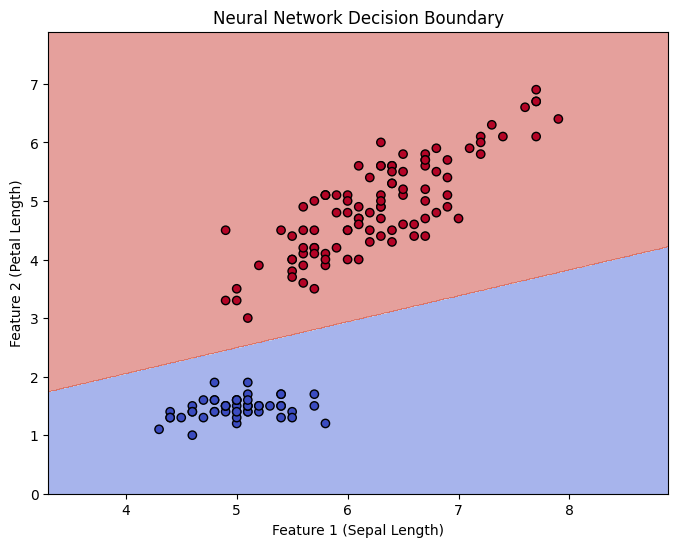

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# Set random seed for reproducibility
np.random.seed(42)


# 1. Data Loading: Hugging Face Iris Dataset

def load_hf_iris_dataset():
    """
    Loads the Iris dataset from Hugging Face, selects two features,
    and converts it to a binary classification problem.
    """
    dataset = load_dataset('scikit-learn/iris', split='train')

    # Access features from the underlying pyarrow.Table via dataset.data
    X_features_raw = (
        dataset.data.column(1).to_numpy(), # 'sepal length (cm)'
        dataset.data.column(3).to_numpy()  # 'petal length (cm)'
    )
    # Stack them into a numpy array where each row is a sample and columns are features
    X_features = np.array(list(zip(*X_features_raw)))

    # The target column contains strings. We evaluate the string condition directly.
    target_strings = dataset.data.column(5).to_numpy()

    # Map 'Iris-setosa' to 0, and the other two species to 1
    Y_labels = (target_strings != 'Iris-setosa').astype(int)

    # Transpose to match standard Neural Network notation (features, samples)
    X = X_features.T
    Y = Y_labels.reshape(1, -1)

    return X, Y

X, Y = load_hf_iris_dataset()
print(f"Data shapes - X: {X.shape}, Y: {Y.shape}")


# 2. Activation Functions and Derivatives

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def relu_backward(Z):
    return (Z > 0).astype(int)


# 3. Neural Network Architecture

def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))

    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}


# 4. Forward Propagation

def forward_propagation(X, parameters):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

def compute_cost(A2, Y):
    m = Y.shape[1]

    # Clip A2 to prevent log(0) or log(1) for numerical stability
    epsilon = 1e-10
    A2_clipped = np.clip(A2, epsilon, 1 - epsilon)

    # Log loss to penalize confident but wrong predictions
    logprobs = np.multiply(np.log(A2_clipped), Y) + np.multiply(np.log(1 - A2_clipped), 1 - Y)
    cost = -np.sum(logprobs) / m
    return np.squeeze(cost)


# 5. Backpropagation

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    W1, W2 = parameters["W1"], parameters["W2"]
    A1, A2, Z1 = cache["A1"], cache["A2"], cache["Z1"]

    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = np.dot(W2.T, dZ2) * relu_backward(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

# FIX applied: lowered learning rate to 0.05
def update_parameters(parameters, grads, learning_rate=0.05):
    W1 = parameters["W1"] - learning_rate * grads["dW1"]
    b1 = parameters["b1"] - learning_rate * grads["db1"]
    W2 = parameters["W2"] - learning_rate * grads["dW2"]
    b2 = parameters["b2"] - learning_rate * grads["db2"]
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}


# 6. Training Loop Execution

print("\nCommencing Network Training...")
n_x = X.shape[0] # 2 features
n_h = 4          # 4 hidden units
n_y = Y.shape[0] # 1 output unit

parameters = initialize_parameters(n_x, n_h, n_y)
epochs = 10000

for i in range(epochs):
    A2, cache = forward_propagation(X, parameters)
    cost = compute_cost(A2, Y)
    grads = backward_propagation(parameters, cache, X, Y)

    # Ensure the lowered learning rate is used
    parameters = update_parameters(parameters, grads, learning_rate=0.05)

    if i % 1000 == 0:
        print(f"Epoch {i:5d} | Cost: {cost:.6f}")

print("\nTraining Complete.")


# 7. Visualization of Decision Boundary

def predict(parameters, X):
    A2, _ = forward_propagation(X, parameters)
    return (A2 > 0.5).astype(int)

def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))


    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.coolwarm, edgecolors='k')

    plt.title("Neural Network Decision Boundary")
    plt.xlabel('Feature 1 (Sepal Length)')
    plt.ylabel('Feature 2 (Petal Length)')
    plt.show()

plot_decision_boundary(lambda x: predict(parameters, x), X, Y)